In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# importing Qiskit
from qiskit import *
#from qiskit.aqua.algorithms import Grover
#from qiskit.aqua.components.oracles import TruthTableOracle
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem
from qiskit.quantum_info import Statevector
from qiskit.algorithms import Grover
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

### Keresés random adatbázisban klasszikusan

In [3]:

def oracle1(input):
    value = 6
    if input == value:
        return True
    else: return False

l = []
for i in range(1000):    

    randlist = random.sample(range(0,10), 10)

    #print(randlist)

    for index, value in enumerate(randlist):
        if oracle1(value) == True:
            #print("pozíció: ", index)
            #print("futtatások száma:", index+1)
            l.append(index+1)
            break
print("Átlagos futási szám:", np.mean(l))

    

Átlagos futási szám: 5.641


### Kvantumosan, Grover algoritmussal

In [58]:
#prepare the oracle as a controlled z gate
oracle = QuantumCircuit(2, name = 'oracle')
oracle.cz(0,1)
oracle.to_gate()
oracle.draw()



q_0: ─■─
      │ 
q_1: ─■─

In [59]:

backend = Aer.get_backend('statevector_simulator')
grover_circ = QuantumCircuit(2,2) #2 qbits, 2 classical registers
grover_circ.h([0,1]) #perpare superpos state with hadamard gate
grover_circ.append(oracle, [0,1])
grover_circ.draw()


┌───┐┌─────────┐
q_0: ┤ H ├┤0        ├
     ├───┤│  oracle │
q_1: ┤ H ├┤1        ├
     └───┘└─────────┘
c_0: ════════════════
                     
c_1: ════════════════

In [60]:
job = execute(grover_circ, backend) #simulate
result = job.result()

sv = result.get_statevector()
np.around(sv,2)

array([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])

In [61]:
reflection = QuantumCircuit(2, name = 'reflection')
reflection.h([0,1])
reflection.z([0,1])
reflection.cz(0,1)
reflection.h([0,1])
reflection.to_gate()
reflection.draw()

┌───┐┌───┐   ┌───┐
q_0: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_1: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

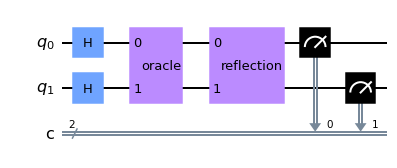

In [62]:
backend = Aer.get_backend('qasm_simulator')
grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle, [0,1])
grover_circ.append(reflection, [0,1])
grover_circ.measure([0,1],[0,1])

grover_circ.draw(output='mpl')

Job Status: job has successfully run


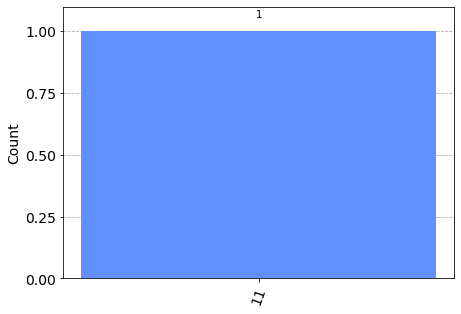

In [9]:
transpiled_grover_circuit = transpile(grover_circ, backend, optimization_level=3)
job = backend.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

job = execute(grover_circ, backend, shots = 1)
result = job.result()
result.get_counts()

results = job.result()
answer = results.get_counts(grover_circ)
plot_histogram(answer)


Grover search with multiple inputs

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]


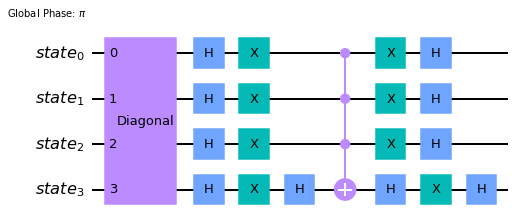

In [69]:
good_state = ['0001', '1111', '1110', '0000'] #these are numbers in binary form
#oracle = Statevector([1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1]) 
#Consider all the numbers that can be represented by 4 bits, order them, 
# the good_states's index will be 1 

sample = '1111'
oracle = Statevector.from_label(sample) #creates staevector from winner sample

print(np.around(oracle,2))
problem = AmplificationProblem(oracle, is_good_state=sample)

grover_circuits = []
for iteration in range(0,20): #experimental test for multiple layers
    grover = Grover(iterations=iteration)
    circuit = grover.construct_circuit(problem) #this constructs the grover circ from the amplification problem, given a sample
    circuit.measure_all()
    grover_circuits.append(circuit)

#grover_circuits[1].draw(output='mpl')
problem.grover_operator.decompose().draw(output='mpl')

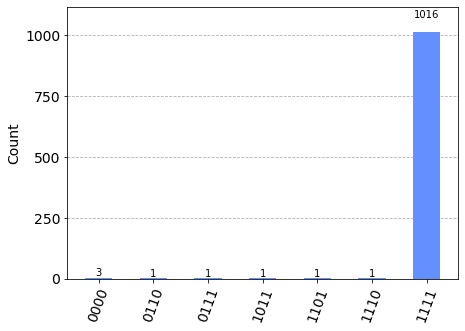

In [77]:
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(grover_circuits[9], aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())
#plt.savefig('1winner_histo.jpg', bbox_inches='tight', dpi=150)

Job Status: job has successfully run


Text(0.5, 0, 'Iterations')

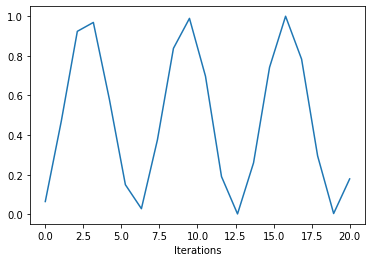

In [78]:
#this job monitor is more tunable
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuits[1], backend, optimization_level=3)
job = backend.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

answers = [] #ppick one of the winning states, and check Grover's succesful findings
sample_count = 0

for i in range(0,20):
    job = execute(grover_circuits[i], backend, shots = 1024)
    result = job.result()
    result.get_counts()
    results = job.result()
    answer = results.get_counts(grover_circuits[i])
    if sample in answer.keys(): #sometimes, it doesn't find it at all
       answers.append(answer[sample]/1024)
       sample_count +=1

plot_histogram(answer)

iters = np.linspace(0,sample_count,sample_count)
plt.plot(iters, answers)
plt.xlabel("Iterations")


#plt.savefig('1winner_iters.jpg', bbox_inches='tight', dpi=150)

In [79]:
print(answers)

[0.064453125, 0.470703125, 0.923828125, 0.96875, 0.5810546875, 0.1494140625, 0.0283203125, 0.3759765625, 0.837890625, 0.9892578125, 0.697265625, 0.1904296875, 0.001953125, 0.259765625, 0.7421875, 1.0, 0.783203125, 0.294921875, 0.00390625, 0.1787109375]


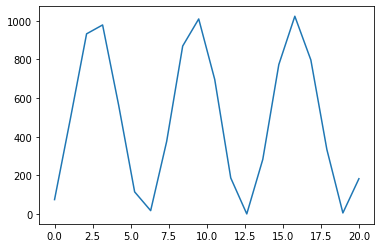

In [13]:

answers = [] #ppick one of the winning states, and check Grover's succesful findings
sample_count = 0

for i in range(0,20):
    job = execute(grover_circuits[i], backend, shots = 1024)
    result = job.result()
    result.get_counts()
    results = job.result()
    answer = results.get_counts(grover_circuits[i])
    if sample in answer.keys(): #sometimes, it doesn't find it at all
       answers.append(answer[sample])
       sample_count +=1

plot_histogram(answer)

iters = np.linspace(0,sample_count,sample_count)
plt.plot(iters, answers)    

Check error for different N/M

In [100]:
nums = [] #numbers to find, winning states
states = [0 for i in range(16) ] #statevector of winning states
findings = [] # save a chosen sample's num of succesful findings
answers = [] # save ansers here

for i in range(0,16):
    strbin = str(bin(i))[2:]
    if len(strbin)<4:
        for j in range(4-len(strbin)):
            strbin = '0'+strbin
    nums.append(strbin)
    states[i]=1

    good_state = nums  #numbers to find, winning states
    oracle = Statevector(states) #statevector of winning states

    problem = AmplificationProblem(oracle, is_good_state=good_state)

    iteration = Grover.optimal_num_iterations(num_solutions=i+1, num_qubits=4)
    grover = Grover(iterations=iteration)
    circuit = grover.construct_circuit(problem) #this constructs the grover circ from the amplification problem, given a sample
    circuit.measure_all()

    sample_count = 0
    sample = '0001'

    job = execute(circuit, backend, shots = 1024)
    result = job.result()
    result.get_counts()
    results = job.result()
    answer = results.get_counts(circuit)
    answers.append(answer)
    if sample in answer.keys(): #sometimes, it doesn't find it at all
       findings.append(answer[sample])

    

print(states)
print(findings)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[4, 471, 307, 265, 193, 148, 104, 73, 52, 67, 68, 63, 66, 76, 65, 72]


In [82]:
plot_histogram(answers[1])

for i in range(len(answers)):
    for j in range(i+1):
        if nums[j] in answers[i]:
            print(answers[i][nums[j]])
    print('---')
            

978
---
479
487
---
328
336
319
---
247
257
271
249
---
199
197
191
198
189
---
149
143
150
155
125
154
---
97
91
107
108
80
98
119
---
75
69
51
68
82
51
60
68
---
73
73
68
56
67
70
65
70
66
---
55
61
61
63
76
71
65
63
62
75
---
69
62
61
80
56
75
72
51
60
60
69
---
60
60
65
60
57
62
54
66
64
61
56
68
---
76
65
83
71
58
72
52
57
52
57
47
61
73
---
64
64
66
57
65
67
60
58
60
68
72
61
63
58
---
71
67
52
75
65
59
68
48
64
67
61
57
58
65
75
---


[0.0341796875, 0.064453125, 0.05078125, 0.0, 0.044921875, 0.1669921875, 0.33203125, 0.525390625, 0.4462890625, 0.37109375, 0.29296875, 0.255859375, 0.1796875, 0.123046875, 0.060546875, 0.0] [0.9658203125, 0.935546875, 0.94921875, 1.0, 0.955078125, 0.8330078125, 0.66796875, 0.474609375, 0.5537109375, 0.62890625, 0.70703125, 0.744140625, 0.8203125, 0.876953125, 0.939453125, 1.0]


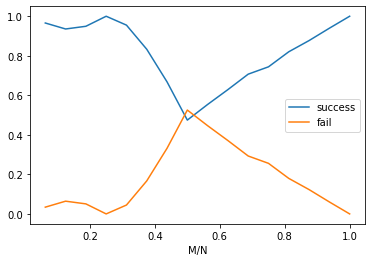

In [105]:
fail = [] #sum of found winners
winner = []

for i in range(len(answers)):
    winnernum = 0
    for j in range(i+1):
        if nums[j] in answers[i]:
            winnernum+=answers[i][nums[j]]
    fail.append((1024-winnernum)/1024)
    winner.append(winnernum/1024)

print(fail, winner)

ratio = []
for k in range(1,17):
    ratio.append(k/16)

plt.plot(ratio, winner[0:16], label='success')
plt.plot(ratio, fail[0:16], label='fail')
plt.xlabel('M/N')
plt.legend()
plt.show()
#plt.savefig('SperFail_by_ratio.jpg', bbox_inches='tight', dpi=150)

In [17]:
problem = AmplificationProblem(oracle, is_good_state=sample)
grover = Grover(iterations=100, sample_from_iterations=True)

In [18]:
iterations = Grover.optimal_num_iterations(num_solutions=1, num_qubits=4)
iterations

3

In [19]:
grover_op = GroverOperator(oracle, insert_barriers=True)
grover_op.decompose().draw(output='mpl')

NameError: name 'GroverOperator' is not defined

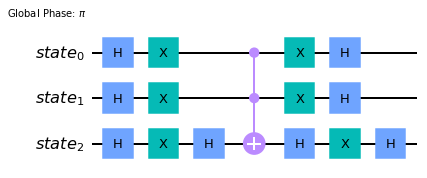

In [ ]:

oracle = QuantumCircuit(3)
oracle.cz(0, 1)
oracle.cz(1,2)
good_state = '110'
problem = AmplificationProblem(oracle, is_good_state=good_state)

grover_circs = []
for iteration in range(0,20): #experimental test for multiple iterations
    grover = Grover(iterations=iteration)
    circuit = grover.construct_circuit(problem) #this constructs the grover circ from the amplification problem, given a sample
    circuit.measure_all()
    grover_circs.append(circuit)

grover_circs[1].draw()
problem.grover_operator.decompose().draw(output='mpl')

In [ ]:
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circs[1], backend, optimization_level=3)
job = backend.run(transpiled_grover_circuit)
job_monitor(job, interval=2)
answers = []

for i in range(0,20):
    job = execute(grover_circs[i], backend, shots = 1024)
    result = job.result()
    result.get_counts()
    results = job.result()
    answer = results.get_counts(grover_circs[i])
  




Job Status: job has successfully run


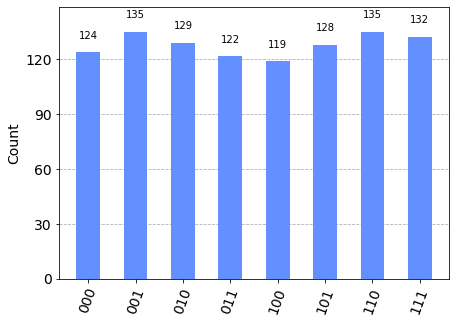

In [ ]:
transpiled_qc = transpile(grover_circs[3], aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())

stackoverflow megoldás

In [ ]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.classicalfunction import classical_function
from qiskit.circuit.classicalfunction.types import Int1
#from qiskit.circuit.classicalfunction import Int1

# define a classical function that can be turned into a circuit
@classical_function
def oracle(x1: Int1, x2: Int1, x3: Int1) -> Int1:
    return (x1 and x2 and x3) or (not x1 and x2 and not x3)

bitcircuit = oracle.synth()  # turn it into a circuit
bitcircuit.draw()


q_0: ───────■──
            │  
q_1: ──■────■──
       │    │  
q_2: ──o────┼──
     ┌─┴─┐┌─┴─┐
q_3: ┤ X ├┤ X ├
     └───┘└───┘

In [ ]:

phaseoracle = QuantumCircuit(4)
phaseoracle.x(3)
phaseoracle.h(3)
phaseoracle.compose(bitcircuit, inplace=True)
phaseoracle.h(3)
phaseoracle.x(3)

backend = Aer.get_backend('statevector_simulator')
grover_circ = QuantumCircuit(4,4) #4 qbits, 4 classical registers
grover_circ.h([0,1,2,3]) #perpare superpos state with hadamard gate
grover_circ.append(oracle, [0,1,2,3])
grover_circ.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤0        ├
     ├───┤│         │
q_1: ┤ H ├┤1        ├
     ├───┤│  Oracle │
q_2: ┤ H ├┤2        ├
     ├───┤│         │
q_3: ┤ H ├┤3        ├
     └───┘└─────────┘
c_0: ════════════════
                     
c_1: ════════════════
                     
c_2: ════════════════
                     
c_3: ════════════════

In [ ]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

In [ ]:
backend = Aer.get_backend('qasm_simulator')

n = 3
qr = QuantumRegister(n, 'q')
cr = ClassicalRegister(n, 'c')

quantcirc = QuantumCircuit(qr,cr)

quantcirc.h(qr[0:n])

quantcirc.append(oracle, [0,1,2])
quantcirc.append(diffuser(n), [0,1,2])


quantcirc.measure(qr,cr)

quantcirc.draw()